In [39]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

#Step 3: Creating Baseline Models

##Part 1: Baseline models for "match" prediction##

Import training and test data. 

In [50]:
reg_dftrain=pd.read_csv("merged_dftrain.csv")
reg_dftest=pd.read_csv("merged_dftest.csv")
dftrain = pd.read_csv("classification_dftrain.csv")
dftest = pd.read_csv("classification_dftest.csv")

Note that since the data is highly skewed (way more no-match than match cases), if our model just predict everything as a "no-match", such model will have over 80% correct rate. However, such model won't tell us anything interesting about our data, and thus we should adopt some other base line models. 

First we can try smapling from a binomial distribution with the proper success rate, which is about 0.16. For each pair of dating people, we randomly draw 0 or 1 from this distribution, and compare with our data. We save the results into dictionaries for all the baseline models, called **base_dict_train** and **base_dict_test** for training and testing results respectively.

In [51]:
base_dict_train = {} #dict for all the baseline models in train
base_dict_test = {} #dict for all the baseline models in test

In [52]:
prob = sum(dftrain['match_x'] == 1)/float(len(dftrain['match_x']))
np.random.seed(1)#set a seed so results are consistent every time we run this notebook
# args: number of trials, probability of each trial, number of times
Ytrain_pred = np.random.binomial(1, prob, len(dftrain))
Ytrain_actual = dftrain['match_x'].values
Ytest_pred = np.random.binomial(1, prob, len(dftest))
Ytest_actual = dftest['match_x'].values

In [53]:
print "binomial baseline training score: ", sum(Ytrain_pred==Ytrain_actual)/float(len(dftrain))
print "binomial baseline test score: ", sum(Ytest_pred==Ytest_actual)/float(len(dftest))

binomial baseline training score:  0.715351393797
binomial baseline test score:  0.742673992674


In [54]:
#add both to dict
base_dict_train['binomial'] = Ytrain_pred
base_dict_test['binomial'] = Ytest_pred

We can see binomial baseline gives fairly good prediction. Alternatively, we can come up with a baseline model with some participant bias. For example, before the dating event, every participant is asked to evaluate how much they care about the other sex in terms of **Attractive**, **Sincere**, **Intelligent**, **Fun** and **Ambitious** (Note that we ignore *Shared Interests* because it's not in self-evaluation), and also how much they evaluate themselves in terms of these 5 aspects. A natural way to think about "matchness" is that two participants meet each other's expectation. Thus, given two participants *A* and *B*, we can calculate a new column that adds up (*actual A* - *expected A*) + (*actual B* - *expected B*) and then get 84-percentile value. Everything below it would be a "no-match" and every above will be a "match". 

In [55]:
def get_value_array(df):
    actualA = df['attr3_1_x']+df['sinc3_1_x']+df['fun3_1_x']+df['intel3_1_x']+df['amb3_1_x']
    expectA = df['attr1_1_y']+df['sinc1_1_y']+df['fun1_1_y']+df['intel1_1_y']+df['amb1_1_y']
    actualB = df['attr3_1_y']+df['sinc3_1_y']+df['fun3_1_y']+df['intel3_1_y']+df['amb3_1_y']
    expectB = df['attr1_1_x']+df['sinc1_1_x']+df['fun1_1_x']+df['intel1_1_x']+df['amb1_1_x']
    return (actualA-expectA)+(actualB-expectB)

In [57]:
train_values = get_value_array(dftrain)
test_values = get_value_array(dftest)
cutoff = np.percentile(train_values, (1-prob)*100) 
print "{} percentile cutoff is: {}".format((1-prob)*100, cutoff)

83.2744405183 percentile cutoff is: 4.62068571278


In [58]:
Ytrain_pred = [1 if x>=cutoff else 0 for x in train_values]
Ytest_pred = [1 if x>=cutoff else 0 for x in test_values]

In [59]:
print "preference baseline training score: ", np.mean(Ytrain_pred==Ytrain_actual)
print "preference baseline test score: ", np.mean(Ytest_pred==Ytest_actual)

preference baseline training score:  0.731448763251
preference baseline test score:  0.749084249084


We can see the scores improved a little bit in both training and test. Now let's add them to dict.

In [60]:
base_dict_train['preference'] = Ytrain_pred
base_dict_test['preference'] = Ytest_pred

Now we can save them on disk for future use with our classifiers.

In [61]:
train_base = pd.DataFrame.from_dict(base_dict_train)
test_base = pd.DataFrame.from_dict(base_dict_test)
train_base.to_csv("train_baseline_results.csv")
test_base.to_csv("test_baseline_results.csv")

One way to fix the unbalanced dataset is to manually create a balanced one. Here we import the balanced train dataset that's also used in classification. 

In [63]:
bal_dftrain = pd.read_csv("classification_dftrain_balanced.csv")
print "match rate in the dataset is: ", np.mean(bal_dftrain['match_x'])

match rate in the dataset is:  0.5


We would like to train the baseline models on this balanced dataset and test on test set. We know this is going to be worse than the unbalanced (due to the nature of this problem), but we still want these baselines to be compared with classification with balanced data later on.

In [64]:
dftrain = bal_dftrain
prob = sum(dftrain['match_x'] == 1)/float(len(dftrain['match_x']))
np.random.seed(1)#set a seed so results are consistent every time we run this notebook
# args: number of trials, probability of each trial, number of times
Ytrain_pred = np.random.binomial(1, prob, len(dftrain))
Ytrain_actual = dftrain['match_x'].values
Ytest_pred = np.random.binomial(1, prob, len(dftest))
Ytest_actual = dftest['match_x'].values
print "binomial baseline (BALANCED) training score: ", sum(Ytrain_pred==Ytrain_actual)/float(len(dftrain))
print "binomial baseline test score: ", sum(Ytest_pred==Ytest_actual)/float(len(dftest))

binomial baseline (BALANCED) training score:  0.518779342723
binomial baseline test score:  0.470695970696


In [65]:
train_values = get_value_array(dftrain)
test_values = get_value_array(dftest)
cutoff = np.percentile(train_values, (1-prob)*100) 
print "{} percentile cutoff is: {}".format((1-prob)*100, cutoff)
Ytrain_pred = [1 if x>=cutoff else 0 for x in train_values]
Ytest_pred = [1 if x>=cutoff else 0 for x in test_values]
print "preference baseline (BALANCED) training score: ", np.mean(Ytrain_pred==Ytrain_actual)
print "preference baseline test score: ", np.mean(Ytest_pred==Ytest_actual)

50.0 percentile cutoff is: 0.283957283246
preference baseline (BALANCED) training score:  0.507042253521
preference baseline test score:  0.521978021978


We can see that for test data, preference baseline is a little bit better than the binomial baseline. 

##Part 2: baseline models for "like" value prediction

The "like" value is a participant's score (on a scale 1-10) on how much she/he likes each person she/he dated. Note that this value is normalized already. 

Since the predictions are numerical and hard to get a definite comparison, let's first just use the average as the prediction to get some idea about the mean square error (or MSER) about the data. 

In [66]:
#get actual train and test "like" values
dftrain = reg_dftrain
dftest = reg_dftest
Ytrain_actual = dftrain['like_x']
Ytest_actual = dftest['like_x']

In [67]:
#avg "like" value each person gives
mergedf = pd.concat([dftrain, dftest])
avg_like = {}
for iid in set(list(mergedf['iid'].values)):
    avg_like[iid] = np.mean(mergedf[mergedf['iid'] == iid]['like_x'])


In [68]:
train_likes = [y for (x,y) in list(set([(x,avg_like[x]) for x in dftrain['iid']]))]
mean_like = np.mean(train_likes)
print "mean like is: ", mean_like

mean like is:  0.0034830369057


In [69]:
#just using mean_like as a prediction
print "train MSE of mean_like as prediction:", mean_squared_error([mean_like]*len(Ytrain_actual), Ytrain_actual)
print "test MSE of mean_like as prediction:",mean_squared_error([mean_like]*len(Ytest_actual), Ytest_actual)

train MSE of mean_like as prediction: 1.00001213155
test MSE of mean_like as prediction: 1.03987823419


Just using an average value gives us an baseline to compare with other baseline models. 

Since different people rate/think how much they "like" someone differently, we will firstly assume that everyone has a specific scale on his/her mind when rating, and thus we will first using their average rating (i.e. "like" value) in the baseline model. It means we assume for an arbitrary person *A*, *A* will always rate someone within the range $[a,b]$, for some $a$ and $b$. 

To take into participants' bias, "like" can be modeled as individual "like" average plus some noise. 

In [70]:
#return best alpha, in terms of lowest mse, and returns best error
def get_pre(iid, avg, bias, Y):
    iid = iid.values
    best_alpha = None
    curr_error = None
    
    for a in alpha:
        values = [avg[iid[idx]]+a*bias[idx] for idx in range(len(iid))]
        error = mean_squared_error(values,Y)
        if curr_error==None or error<curr_error:
            curr_error = error
            best_alpha = a
    return curr_error

In [71]:
Ytrain_pred = [avg_like[dftrain['iid'].values[idx]] for idx in range(len(dftrain))]
Ytest_pred = [avg_like[dftest['iid'].values[idx]] for idx in range(len(dftest))]
print "train MSE of user average as prediction:", mean_squared_error(Ytrain_pred, Ytrain_actual)
print "test MSE of user average as prediction:", mean_squared_error(Ytest_pred, Ytest_actual)

train MSE of user average as prediction: 0.665185734789
test MSE of user average as prediction: 0.68148615854


The MSEs are much better. However, since we use "like" results to build our baseline model, this seems a little bit cheating because we asusme every user will in general have a lower or higher scoring system, which may not be true in reality. 

Without looking at "like" values, we can just use the "values", which is the bias we preference we mannully calculated, for trian and test and run a naive linear regression with the training "like". 

In [202]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_values[:,np.newaxis], np.array(Ytrain_actual))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [204]:
Ytrain_pred = model.predict(train_values[:,np.newaxis])
Ytest_pred = model.predict(test_values[:, np.newaxis])
print "train MSE of preference as prediction:", mean_squared_error(Ytrain_pred, Ytrain_actual)
print "test MSE of preference as prediction:", mean_squared_error(Ytest_pred, Ytest_actual)

train MSE of preference as prediction: 0.993909122438
test MSE of preference as prediction: 1.03677458544


The MSEs are not that good, but still have some improvement comparing to just using the average. We can actually plot the two linear models. 

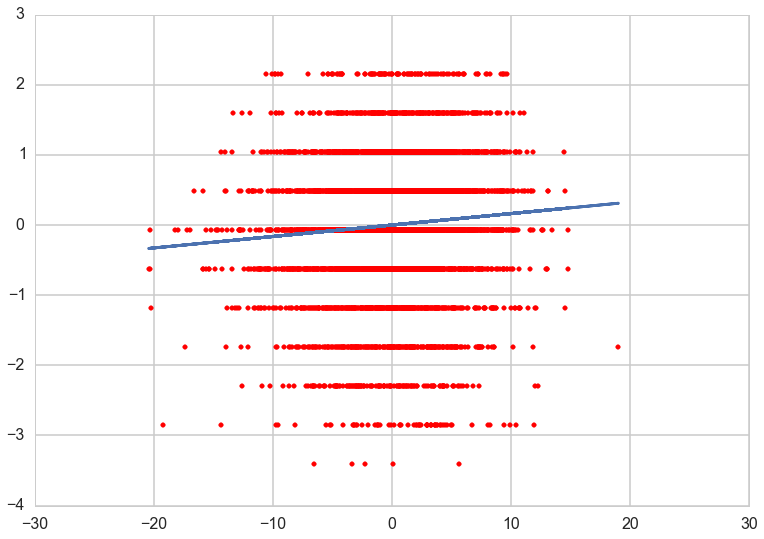

In [143]:
plt.scatter(train_values, Ytrain_actual, color="red")
plt.plot(train_values, Ytrain_pred)

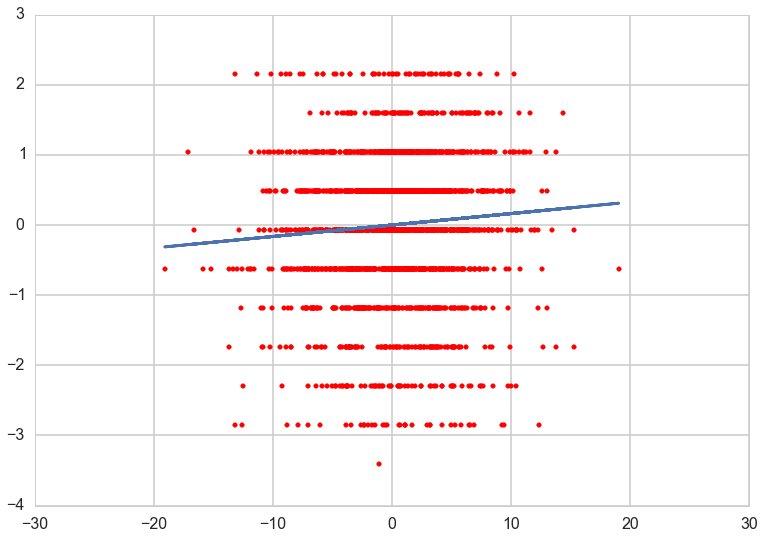

In [144]:
plt.scatter(test_values, Ytest_actual, color="red")
plt.plot(test_values, Ytest_pred)